<h1><center>Heart Failure Prediction: Analysis and modeling</center></h1>

<center><img src="https://pediatricheartspecialists.com/images/answers/Normal_Heart_Anatomy_and_Blood_Flow.jpg"></center>


<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:purple; border:0' role="tab" aria-controls="home"><center>Quick navigation</center></h3>

* [1. Data analysis and Visualization](#1)
* [2. Modeling](#2)
* [3. Optimization](#3)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import optuna
from optuna.samplers import TPESampler
from sklearn.pipeline import Pipeline

/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


<a id="1"></a>
<h2 style='background:purple; border:0; color:white'><center>Data analysis and Visualization<center><h2>

### In this section we are going to do quick overview of available variables

In [2]:
df = pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Let's see percent of NaNs for every column

In [3]:
for col in df.columns:
    print(col, str(round(100* df[col].isnull().sum() / len(df), 2)) + '%')

age 0.0%
anaemia 0.0%
creatinine_phosphokinase 0.0%
diabetes 0.0%
ejection_fraction 0.0%
high_blood_pressure 0.0%
platelets 0.0%
serum_creatinine 0.0%
serum_sodium 0.0%
sex 0.0%
smoking 0.0%
time 0.0%
DEATH_EVENT 0.0%


In [4]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [5]:
fig = px.histogram(df, "age", nbins=25, title='Patients age distribution', width=700)
fig.show()

In [6]:
ds = df['anaemia'].value_counts().reset_index()
ds.columns = ['anaemia', 'count']
fig = px.pie(ds, values='count', names="anaemia", title='Anaemia bar chart', width=600, height=500)
fig.show()

In [7]:
fig = px.histogram(df, "creatinine_phosphokinase", nbins=15, title='Creatinine phosphokinase distribution', width=700)
fig.show()

In [8]:
ds = df['diabetes'].value_counts().reset_index()
ds.columns = ['diabetes', 'count']
fig = px.pie(ds, values='count', names="diabetes", title='Diabetes bar chart', width=600, height=500)
fig.show()

In [9]:
fig = px.histogram(df, "ejection_fraction", nbins=15, title='Ejection_fraction distribution', width=700)
fig.show()

In [10]:
ds = df['high_blood_pressure'].value_counts().reset_index()
ds.columns = ['high_blood_pressure', 'count']
fig = px.pie(ds, values='count', names="high_blood_pressure", title='High blood pressure bar chart', width=600, height=500)
fig.show()

In [11]:
fig = px.histogram(df, "platelets", nbins=25, title='Platelets distribution', width=700)
fig.show()

In [12]:
fig = px.histogram(df, "serum_creatinine", nbins=25, title='Serum creatinine distribution', width=700)
fig.show()

In [13]:
fig = px.histogram(df, "serum_sodium", nbins=25, title='Serum sodium distribution', width=700)
fig.show()

In [14]:
ds = df['sex'].value_counts().reset_index()
ds.columns = ['sex', 'count']
fig = px.pie(ds, values='count', names="sex", title='Gender bar chart', width=600, height=500)
fig.show()

In [15]:
ds = df['smoking'].value_counts().reset_index()
ds.columns = ['smoking', 'count']
fig = px.bar(ds, x='count', y="smoking", orientation='h', title='Smoking bar chart', width=600, height=400)
fig.show()

In [16]:
ds = df['DEATH_EVENT'].value_counts().reset_index()
ds.columns = ['DEATH_EVENT', 'count']
fig = px.bar(ds, x='count', y="DEATH_EVENT", orientation='h', title='DEATH_EVENT bar chart', width=600, height=400)
fig.show()

### Correlation matrix

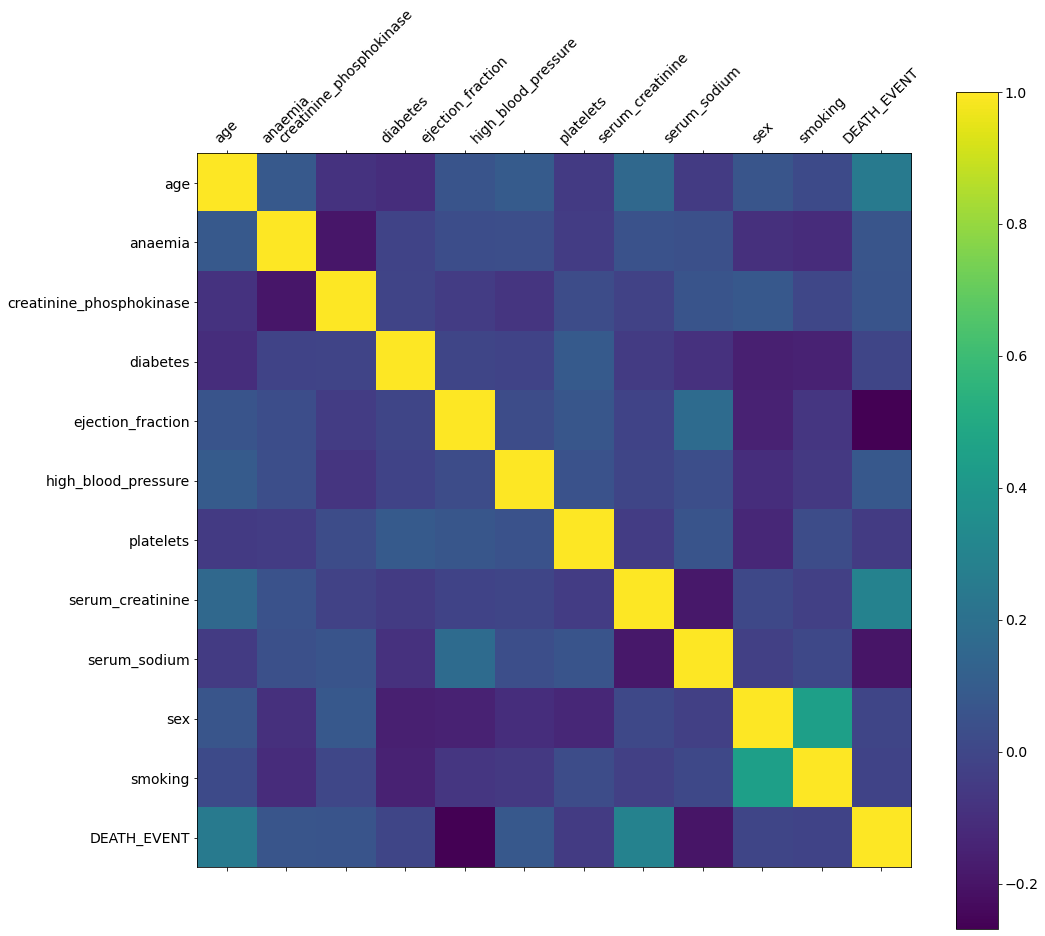

In [17]:
df = df.drop(['time'], axis=1)
f = plt.figure(figsize=(16, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

<a id="2"></a>
<h2 style='background:purple; border:0; color:white'><center>Modeling<center><h2>

### Lets train Logistic Regression model as a quick baseline and check the results

In [18]:
X = df.copy()
y = X['DEATH_EVENT']
X = X.drop(['DEATH_EVENT'], axis=1)

X, X_test, y, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True)

In [19]:
model = LogisticRegression(random_state=0)
model.fit(X, y)
preds = model.predict(X_test)
print('Logistic Regression ', accuracy_score(y_test, preds))

Logistic Regression  0.6833333333333333


### Let's check a confusion matrix

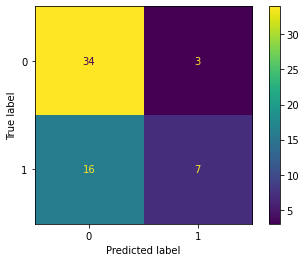

In [20]:
plot_confusion_matrix(model, X_test, y_test)
plt.show()

### We deal with imbalanced classification problem so accuracy is not really useful metric. Let's try f1-score and see results.

In [21]:
print('Logistic Regression f1-score', f1_score(y_test, preds))
print('Logistic Regression precision', precision_score(y_test, preds))
print('Logistic Regression recall', recall_score(y_test, preds))

Logistic Regression f1-score 0.42424242424242425
Logistic Regression precision 0.7
Logistic Regression recall 0.30434782608695654


### Let's try to improve our f1-score and use LightGBM model

In [22]:
model = LGBMClassifier(random_state=0)
model.fit(X, y)
preds = model.predict(X_test)
print('LightGBM f1-score', f1_score(y_test, preds))
print('LightGBM precision', precision_score(y_test, preds))
print('LightGBM recall', recall_score(y_test, preds))

LightGBM f1-score 0.4210526315789474
LightGBM precision 0.5333333333333333
LightGBM recall 0.34782608695652173


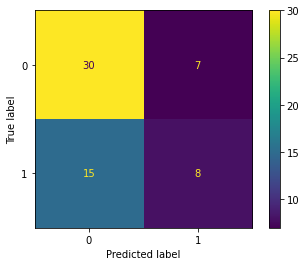

In [23]:
plot_confusion_matrix(model, X_test, y_test)
plt.show()

### The results are not really better. Let's try to drop features with absolute correlation with target less than 0.05.

In [24]:
for col in X.columns:
    if abs(X[col].corr(y)) < 0.05:
        X = X.drop([col], axis=1)
        X_test = X_test.drop([col], axis=1)

### After removing some features  we have next set:

In [25]:
X

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,serum_creatinine,serum_sodium
134,81.0,0,4540,0,35,0,1.18,137
145,50.0,0,185,0,30,0,0.70,141
63,45.0,0,582,0,35,0,1.00,145
292,52.0,0,190,1,38,0,1.00,140
284,50.0,1,54,0,40,0,0.80,141
...,...,...,...,...,...,...,...,...
251,55.0,0,572,1,35,0,0.80,143
192,50.0,1,121,1,40,0,0.70,130
117,85.0,1,102,0,60,0,3.20,138
47,60.0,0,582,1,38,1,0.60,138


In [26]:
model = LGBMClassifier(random_state=0)
model.fit(X, y)
preds = model.predict(X_test)
print('LightGBM f1-score', f1_score(y_test, preds))
print('LightGBM precision', precision_score(y_test, preds))
print('LightGBM recall', recall_score(y_test, preds))

LightGBM f1-score 0.5365853658536586
LightGBM precision 0.6111111111111112
LightGBM recall 0.4782608695652174


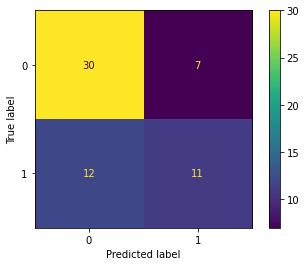

In [27]:
plot_confusion_matrix(model, X_test, y_test)
plt.show()

## Lets try XGBoost model

In [28]:
model = XGBClassifier(random_state=0)
model.fit(X, y)
preds = model.predict(X_test)
print('XGBClassifier f1-score', f1_score(y_test, preds))
print('XGBClassifier precision', precision_score(y_test, preds))
print('XGBClassifier recall', recall_score(y_test, preds))

XGBClassifier f1-score 0.4
XGBClassifier precision 0.5833333333333334
XGBClassifier recall 0.30434782608695654


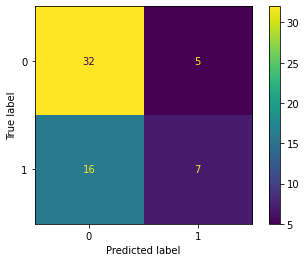

In [29]:
plot_confusion_matrix(model, X_test, y_test)
plt.show()

## The score for LightGBM became better. Lets do hyperparameters optimization next. We will use optuna for it.

<a id="3"></a>
<h2 style='background:red; border:0; color:white'><center>Optimization<center><h2>

In [30]:
def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 30)
    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    model = LGBMClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, num_leaves=num_leaves, min_child_samples=min_child_samples,
                           random_state=0)
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X, y)
    preds = model.predict(X_test)
    score = f1_score(y_test, preds)
    return score

# 自动化调参
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

lgb_params = study.best_params
lgb_params['random_state'] = 0
lgb = LGBMClassifier(**lgb_params)
lgb.fit(X, y)
preds = lgb.predict(X_test)
print('Optimized LightGBM: ', accuracy_score(y_test, preds))
print('Optimized LightGBM f1-score', f1_score(y_test, preds))
print('Optimized LightGBM precision', precision_score(y_test, preds))
print('Optimized LightGBM recall', recall_score(y_test, preds))

[I 2020-08-29 01:04:57,351] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 14, 'n_estimators': 48, 'learning_rate': 0.7151893948534829, 'num_leaves': 4933, 'min_child_samples': 198}. Best is trial 0 with value: 0.0.
[I 2020-08-29 01:04:57,377] Trial 1 finished with value: 0.36363636363636365 and parameters: {'max_depth': 9, 'n_estimators': 10, 'learning_rate': 0.6235637344296027, 'num_leaves': 3470, 'min_child_samples': 61}. Best is trial 1 with value: 0.36363636363636365.
[I 2020-08-29 01:04:57,430] Trial 2 finished with value: 0.25806451612903225 and parameters: {'max_depth': 3, 'n_estimators': 487, 'learning_rate': 0.8121687475586203, 'num_leaves': 2224, 'min_child_samples': 91}. Best is trial 1 with value: 0.36363636363636365.
[I 2020-08-29 01:04:57,449] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 19, 'n_estimators': 166, 'learning_rate': 0.8360787799295012, 'num_leaves': 2165, 'min_child_samples': 200}. Best is trial 1 with value: 0.3636363636363

Optimized LightGBM:  0.7666666666666667
Optimized LightGBM f1-score 0.6666666666666666
Optimized LightGBM precision 0.7368421052631579
Optimized LightGBM recall 0.6086956521739131


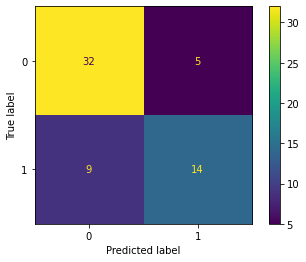

In [31]:
plot_confusion_matrix(lgb, X_test, y_test)
plt.show()

### We can see that f1-score became better.

### Now we will try to improve model using Recursive feature elimination and find best the set of features for empty LightGBM model

In [32]:
for i in range(1, len(X.columns)+1):
    rfe = RFE(estimator=DecisionTreeClassifier(random_state=0), n_features_to_select=i)
    pipeline = Pipeline(steps=[('s',rfe),('m',LGBMClassifier(random_state=0))])
    pipeline.fit(X, y)
    preds = pipeline.predict(X_test)
    print('Number of features: ', i)
    print('LightGBM f1-score', f1_score(y_test, preds))

Number of features:  1
LightGBM f1-score 0.2
Number of features:  2
LightGBM f1-score 0.5263157894736841
Number of features:  3
LightGBM f1-score 0.4210526315789474
Number of features:  4
LightGBM f1-score 0.5
Number of features:  5
LightGBM f1-score 0.3888888888888889
Number of features:  6
LightGBM f1-score 0.4210526315789474
Number of features:  7
LightGBM f1-score 0.46153846153846156
Number of features:  8
LightGBM f1-score 0.5365853658536586


### We can see good scores for N_features = 2 and N_features = 8. For second case we already know results of optimization. Let's check the same for N_feauters = 2.

In [33]:
def create_model(trial):
    rfe = RFE(estimator=DecisionTreeClassifier(random_state=0), n_features_to_select=2)
    max_depth = trial.suggest_int("max_depth", 2, 30)
    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    model = Pipeline(steps=[('s',rfe), ('m', LGBMClassifier(learning_rate=learning_rate, n_estimators=n_estimators, 
                                                            max_depth=max_depth, num_leaves=num_leaves, 
                                                            min_child_samples=min_child_samples, random_state=0))
                           ]
                    )
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X, y)
    preds = model.predict(X_test)
    score = f1_score(y_test, preds)
    return score

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

lgb_params = study.best_params
lgb_params['random_state'] = 0
lgb = LGBMClassifier(**lgb_params)
rfe = RFE(estimator=DecisionTreeClassifier(random_state=0), n_features_to_select=2)
model = Pipeline(steps=[('s',rfe), ('m', lgb)])
model.fit(X, y)
preds = model.predict(X_test)
print('Optimized LightGBM: ', accuracy_score(y_test, preds))
print('Optimized LightGBM f1-score', f1_score(y_test, preds))
print('Optimized LightGBM precision', precision_score(y_test, preds))
print('Optimized LightGBM recall', recall_score(y_test, preds))

[I 2020-08-29 01:05:08,160] Trial 0 finished with value: 0.4878048780487805 and parameters: {'max_depth': 17, 'n_estimators': 389, 'learning_rate': 0.6818203309214534, 'num_leaves': 4986, 'min_child_samples': 4}. Best is trial 0 with value: 0.4878048780487805.
[I 2020-08-29 01:05:08,208] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 3, 'n_estimators': 488, 'learning_rate': 0.060225565606722674, 'num_leaves': 3944, 'min_child_samples': 122}. Best is trial 0 with value: 0.4878048780487805.
[I 2020-08-29 01:05:08,306] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 13, 'n_estimators': 431, 'learning_rate': 0.35815223115430833, 'num_leaves': 2448, 'min_child_samples': 102}. Best is trial 0 with value: 0.4878048780487805.
[I 2020-08-29 01:05:08,424] Trial 3 finished with value: 0.18750000000000003 and parameters: {'max_depth': 23, 'n_estimators': 397, 'learning_rate': 0.5701968133982026, 'num_leaves': 4182, 'min_child_samples': 71}. Best is trial 0 with value

Optimized LightGBM:  0.7
Optimized LightGBM f1-score 0.6086956521739131
Optimized LightGBM precision 0.6086956521739131
Optimized LightGBM recall 0.6086956521739131


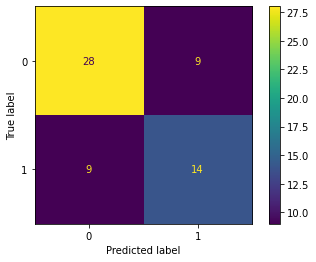

In [34]:
plot_confusion_matrix(model, X_test, y_test)
plt.show()

## TBD